In [1]:
# Python Support Vector Machine Classifier (Machine Learning) eMini SP500 Futures Trading Strategy
# Copyright Sheikh Pancham January 2020 sheikh.pancham@gmail.com

# Maximize Jupyter Notebook Display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import the standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC # import SVC class which will be used to instantiate a support vector classifier.
from sklearn.preprocessing import scale # import scale to scale feature set
import talib as ta

class SVCTradingStrategy():
    
    def __getData__(self):
        # Retrieve historical intraday data for USD eMini SP500 Futures
        csv_file ='es.d.15m.15yrs.exchange.csv'
        self.df = pd.read_csv(csv_file, parse_dates=[['Date', 'Time']])
        self.df.index = pd.to_datetime(self.df['Date_Time'])
        print(self.df.head())
        
    def __calculateMarketReturn__(self):
        self.df['MarketReturn'] = np.log(self.df['Open'].shift(-2)/self.df['Open'].shift(-1)) 
    
    def __setSignal__(self):
        self.df['Signal'] = 0
        self.df.loc[self.df['MarketReturn'] > 0, 'Signal'] = 1
        self.df.loc[self.df['MarketReturn'] < 0, 'Signal'] = -1
        
    def _prepareFeatureSet_(self):
        self.__calculateMarketReturn__()
        self.__setSignal__()
        self.df = self.df.dropna()
        
        m = 10
        self.df['SMA'] = ta.SMA(np.array(self.df['Close']), timeperiod=m)
        self.df = self.df.dropna()
        self.df['CORREL'] = ta.CORREL(np.array(self.df['High']), np.array(self.df['Low']), timeperiod=m)
        self.df = self.df.dropna()
        
        self.df.loc[self.df['CORREL'] > 1, 'CORREL'] = 1
        self.df.loc[self.df['CORREL'] < -1, 'CORREL'] = -1
    
        self.df['LINEARREG_SLOPE'] = ta.LINEARREG_SLOPE(np.array(self.df['Close'].shift(2)), timeperiod=20)
        self.df = self.df.dropna()
        
        self.df['MOM'] = ta.MOM(np.array(self.df['Close']), timeperiod=m)
        self.df = self.df.dropna()
        
        self.df['STDDEV'] = ta.STDDEV(np.array(self.df['Close']), timeperiod=m, nbdev=1)
        self.df = self.df.dropna()
        
        self.df['RSI'] = ta.RSI(np.array(self.df['Close'].shift(3)), timeperiod=m)
        self.df = self.df.dropna()
        
        self.df['SAR'] = ta.SAR(np.array(self.df['High'].shift(1)), np.array(self.df['Low'].shift(1)), acceleration=0.2, maximum=0.2)
        self.df = self.df.dropna()
        
        self.df['ADX'] = ta.ADX(np.array(self.df['High'].shift(1)), np.array(self.df['Low'].shift(1)), np.array(self.df['Open']), timeperiod=m)
        self.df = self.df.dropna()
        
        # Use the returns for the last 20 15-minute intervals
        n = 20
        for i in range(1, n):
            self.df['MarketReturn%i' % i] = self.df['MarketReturn'].shift(i)
        
        self.df = self.df.dropna()
#         self.X = self.df.drop(['Date_Time','MarketReturn','Signal'], axis=1)
        self.X = self.df.drop(['Date_Time','Open','Close','High','Low','MarketReturn','Signal'], axis=1)
        self.Y = self.df['Signal']
        
    def _Scale_Train_Test_Split_(self):
#         Scale and Split Train and Test Data Sets
        self.begintraindt = '2019-11-22'
        self.endtraindt = '2020-04-03'
        self.begintestdt ='2020-04-03'
        self.endtestdt = '2020-05-06'      
        self.X_scaled = pd.DataFrame(scale(self.X), columns=self.X.columns, index=self.df.index)
        self.X_train = pd.DataFrame(self.X_scaled.loc[self.begintraindt : self.endtraindt], columns=self.X_scaled.columns)
        self.Y_train = self.Y[self.begintraindt : self.endtraindt]
        self.X_test = pd.DataFrame(self.X_scaled.loc[self.begintestdt : self.endtestdt], columns=self.X_scaled.columns)
        self.Y_test = self.Y[self.begintestdt : self.endtestdt]
        
    def _fitCLS_(self):
        self.cls = 0
        self.cls = SVC(C=1000, gamma='auto', kernel='rbf')
        self.cls.fit(self.X_train, self.Y_train)
        self.train_accuracy = self.cls.score(self.X_train, self.Y_train)
        print('SVC Train Accuracy = {:.4f}'.format(self.train_accuracy))
        
    def _predictCLS_(self):
        self.Y_predict = 0
        self.Y_predict = self.cls.predict(self.X_test)
        self.test_accuracy = self.cls.score(self.X_test, self.Y_test)
        print('SVC Test Accuracy = {:.4f}'.format(self.test_accuracy))
        self.df['PredictSignal'] = 0
        self.df.loc[self.begintraindt : self.endtraindt, 'PredictSignal'] = self.cls.predict(self.X_train)
        self.df.loc[self.begintestdt : self.endtestdt, 'PredictSignal'] = self.Y_predict
        
    def _calculateStrategyReturn_(self):
        self.df['StrategyReturn'] = 0.0
        self.df['StrategyReturn'] = self.df.loc[self.begintestdt : self.endtestdt, 'MarketReturn'] * self.df.loc[self.begintestdt : self.endtestdt, 'PredictSignal']
        
    def _calculateCumulativeMarketReturn_(self):
        self.df['CumulativeMarketReturn'] = 0.0
        self.df['CumulativeMarketReturn'] = np.cumsum(self.df.loc[self.begintestdt : self.endtestdt, 'MarketReturn'])
        
    def _calculateCumulativeStrategyReturn_(self):
        self.df['CumulativeStrategyReturn'] = 0.0
        self.df['CumulativeStrategyReturn'] = np.cumsum(self.df.loc[self.begintestdt : self.endtestdt, 'StrategyReturn'])
        
    def _plotCumulativeReturn_(self):
        Stdv = np.std(self.df.loc[self.begintestdt : self.endtestdt, 'CumulativeStrategyReturn'])
        print ('Stdv:', Stdv)
        Sharpe = (self.df['CumulativeStrategyReturn'].iloc[-1] - self.df['CumulativeMarketReturn'].iloc[-1]) / Stdv
        print('Sharpe Ratio:', Sharpe)
        print('Strategy Return:', self.df['CumulativeStrategyReturn'].iloc[-1])
        print('Market Return:', self.df['CumulativeMarketReturn'].iloc[-1])
        plt.plot(self.df['CumulativeStrategyReturn'], color='g', label='Strategy Return')
        plt.plot(self.df['CumulativeMarketReturn'], color='b', label='Market Return')
        plt.legend(loc='best')
        plt.title(str(' SVC Strategy Return ('+self.begintestdt+' - '+self.endtestdt+')'))
        plt.ylabel('Cumulative Return')
        plt.grid()
        plt.show()
        
    def calculateSVCStrategyReturn(self):
        self.__getData__()
        self._prepareFeatureSet_()
        self._Scale_Train_Test_Split_()
        self._fitCLS_()
        self._predictCLS_()
        self._calculateStrategyReturn_()
        self._calculateCumulativeMarketReturn_()
        self._calculateCumulativeStrategyReturn_()
        self._plotCumulativeReturn_()

                              Date_Time     Open     High      Low    Close  \
Date_Time                                                                     
2005-05-06 08:45:00 2005-05-06 08:45:00  1118.50  1118.75  1116.00  1117.25   
2005-05-06 09:00:00 2005-05-06 09:00:00  1117.25  1118.75  1115.25  1117.25   
2005-05-06 09:15:00 2005-05-06 09:15:00  1117.25  1118.00  1113.75  1114.75   
2005-05-06 09:30:00 2005-05-06 09:30:00  1114.75  1117.25  1114.25  1116.50   
2005-05-06 09:45:00 2005-05-06 09:45:00  1116.75  1117.75  1115.00  1115.25   

                        Up   Down  
Date_Time                          
2005-05-06 08:45:00  23504  31838  
2005-05-06 09:00:00  24471  25606  
2005-05-06 09:15:00  22001  31117  
2005-05-06 09:30:00  24035  18834  
2005-05-06 09:45:00  11634  15385  
SVC Train Accuracy = 0.9766
SVC Test Accuracy = 0.5444
Stdv: 0.09646954530472687
Sharpe Ratio: 3.1026818905977303
Strategy Return: 0.41748257820373447
Market Return: 0.11816826699256111


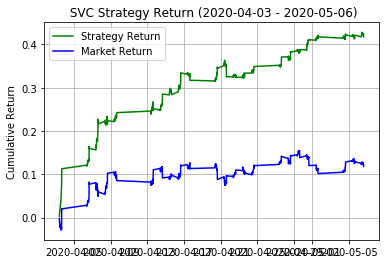

In [2]:
svc = SVCTradingStrategy()
svc.calculateSVCStrategyReturn()